In [10]:
# Importing the necessary libraries
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install keras 
from tensorflow.keras import models,layers
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing import image
!pip install --upgrade tensorflow-addons
import tensorflow_addons as tfa  # Import tensorflow_addons


In [11]:
# Setting up batch size and class type
batch = 32
classes = 'binary'

# Define the paths for train, test, and validation datasets
train='../input/dataset/train'
test='../input/dataset/test'
val='../input/dataset/val'


In [12]:
# Define the image data generators
train_datagen = image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
validation_datagen= image.ImageDataGenerator()

test_datagen= image.ImageDataGenerator()

# Generate data batches for training, validation, and testing
train_generator = train_datagen.flow_from_directory(
    train,
    target_size = (224,224),
    batch_size = batch,
    class_mode = classes)


validation_generator = validation_datagen.flow_from_directory(
    val,
    target_size = (224,224),
    batch_size = batch,
    shuffle=True,
    class_mode = classes)

test_generator = test_datagen.flow_from_directory(
    test,
    target_size = (224,224),
    batch_size = batch,
    class_mode = classes)

# Get the class names
class_names=validation_generator.class_indices
class_names
len(class_names)

Found 4946 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Found 126 images belonging to 2 classes.


2

In [13]:
def show_images(gen):
    '''
    This function take the data generator and show sample of the images
    '''

    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator

    # calculate number of displayed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

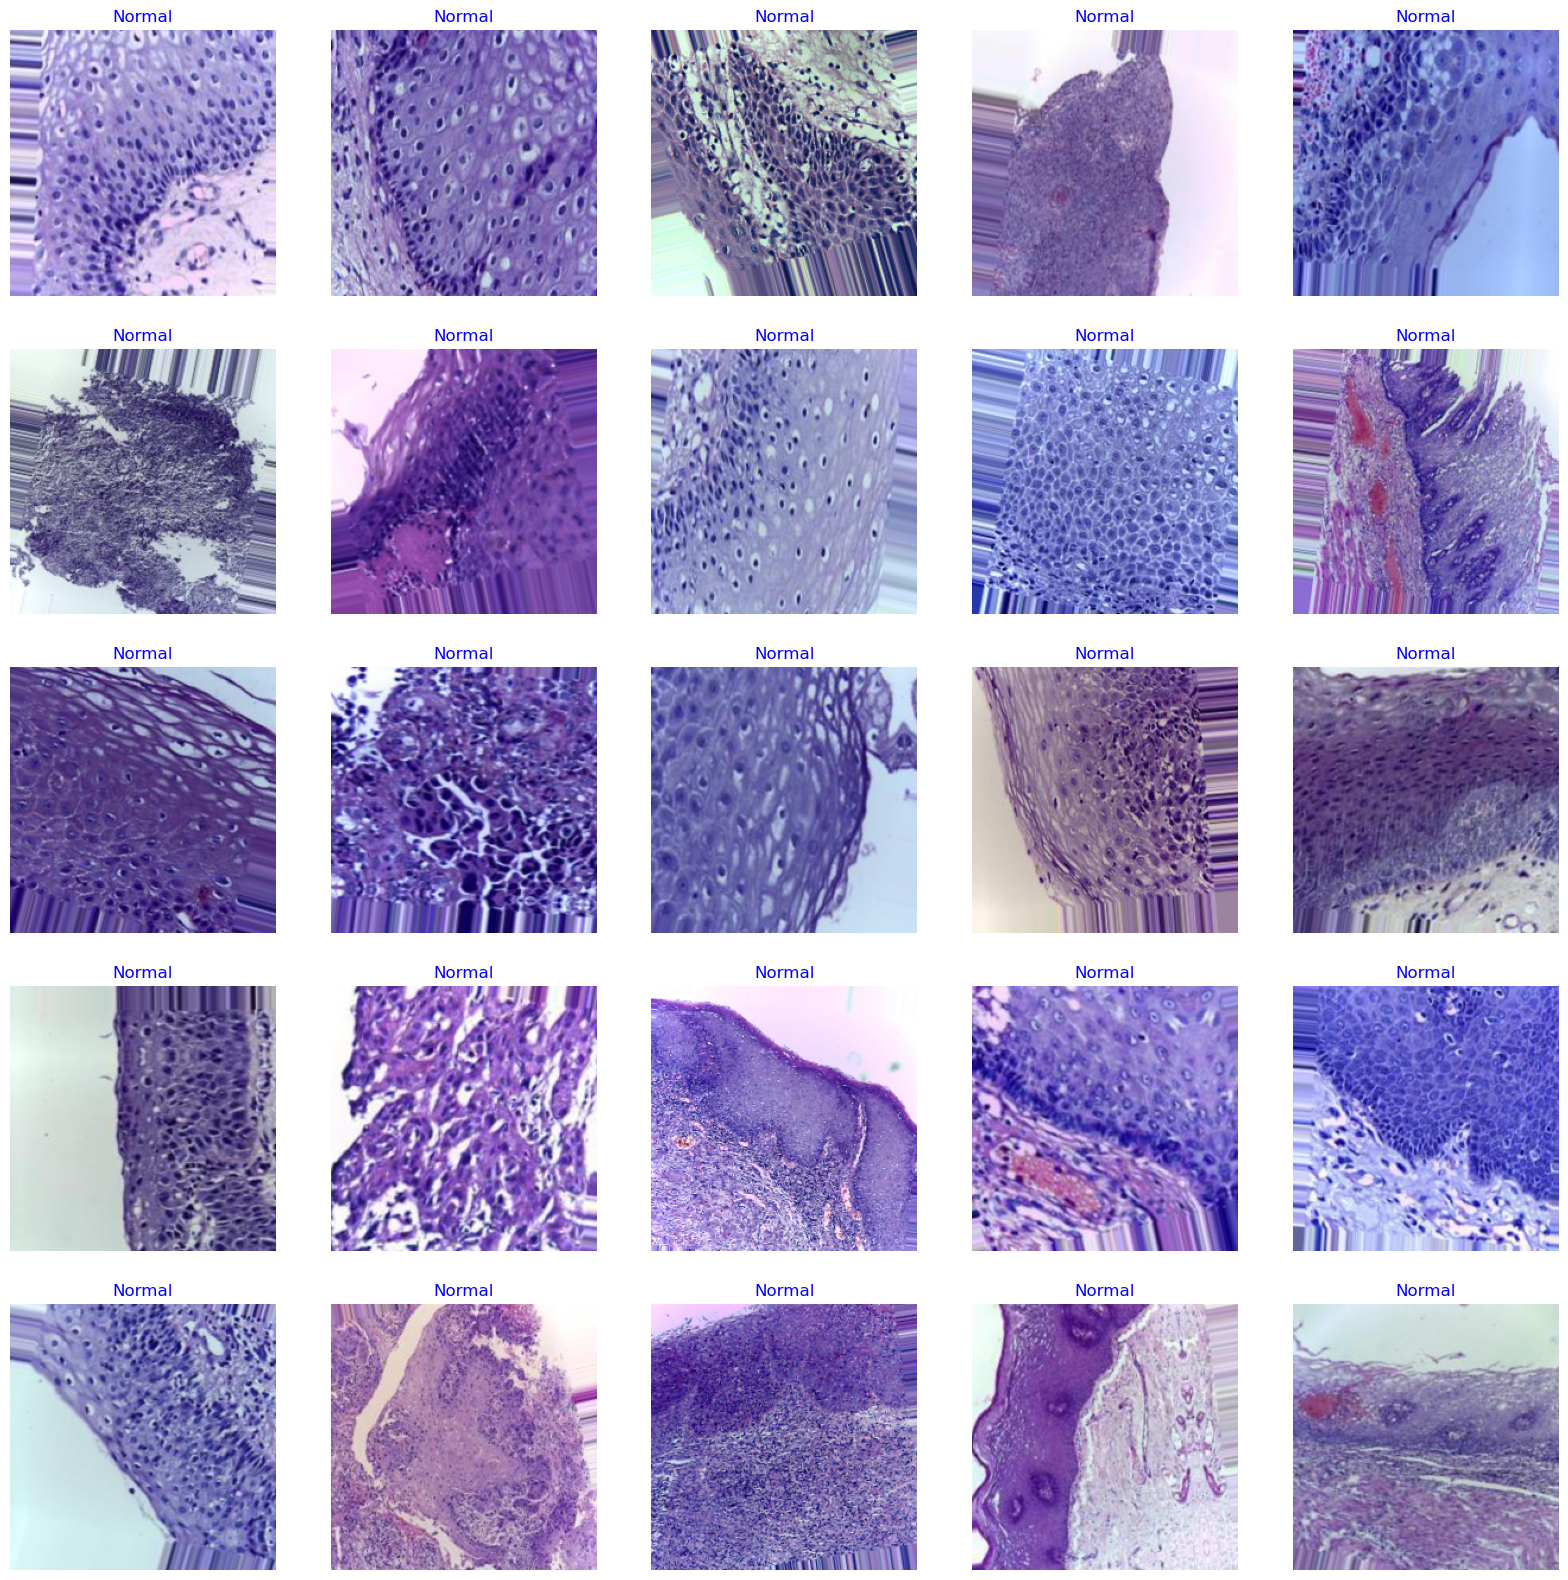

In [14]:
show_images(train_generator)

In [15]:
# Setting the base model
base_for_model = tf.keras.applications.InceptionV3(weights='imagenet', input_shape=(224,224,3), include_top=False)
for layer in base_for_model.layers:
    layer.trainable = False


In [16]:
# Build the model architecture
model = Sequential()
model.add(base_for_model) 
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))
model.add(GlobalMaxPooling2D()) 
model.add(BatchNormalization())
model.add(Dense(512, activation = 'relu')) 
model.add(BatchNormalization()) 
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 dense_5 (Dense)             (None, 5, 5, 512)         1049088   
                                                                 
 batch_normalization_192 (Ba  (None, 5, 5, 512)        2048      
 tchNormalization)                                               
                                                                 
 dense_6 (Dense)             (None, 5, 5, 512)         262656    
                                                                 
 global_max_pooling2d_1 (Glo  (None, 512)              0         
 balMaxPooling2D)                                                
                                                                 
 batch_normalization_193 (Ba  (None, 512)             

In [17]:
# Define the F1 score metric
def f1_score_metric(y_true, y_pred):
    y_pred = tf.round(y_pred)
    return 2 * tf.reduce_sum(y_true * y_pred) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + tf.keras.backend.epsilon())


In [18]:
# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy','Precision','Recall','AUC',f1_score_metric]
)

In [19]:
# Train the model
history=model.fit(
    train_generator,
    epochs=10,
    batch_size=64,
    validation_data=validation_generator
)

Epoch 1/10
155/155 [==============================] - 202s 1s/step - loss: 0.7313 - accuracy: 0.6423 - precision: 0.6491 - recall: 0.6432 - auc: 0.6954 - f1_score_metric: 0.6425 - val_loss: 0.6252 - val_accuracy: 0.6833 - val_precision: 0.7935 - val_recall: 0.7935 - val_auc: 0.6446 - val_f1_score_metric: 0.7800
Epoch 2/10
155/155 [==============================] - 116s 748ms/step - loss: 0.5867 - accuracy: 0.6969 - precision: 0.7024 - recall: 0.6993 - auc: 0.7686 - f1_score_metric: 0.6987 - val_loss: 0.9454 - val_accuracy: 0.6083 - val_precision: 0.8082 - val_recall: 0.6413 - val_auc: 0.5334 - val_f1_score_metric: 0.7179
Epoch 3/10
155/155 [==============================] - 120s 775ms/step - loss: 0.5498 - accuracy: 0.7238 - precision: 0.7296 - recall: 0.7244 - auc: 0.7999 - f1_score_metric: 0.7249 - val_loss: 0.7779 - val_accuracy: 0.7167 - val_precision: 0.8152 - val_recall: 0.8152 - val_auc: 0.6409 - val_f1_score_metric: 0.8135
Epoch 4/10
155/155 [==============================] - 1

In [20]:
score=model.evaluate(validation_generator)
score

4/4 [==============================] - 7s 2s/step - loss: 0.6156 - accuracy: 0.7417 - precision: 0.8144 - recall: 0.8587 - auc: 0.6949 - f1_score_metric: 0.8369


[0.6155757904052734,
 0.7416666746139526,
 0.8144329786300659,
 0.8586956262588501,
 0.6948758363723755,
 0.8369281888008118]

**Prediction of Oral Cancer using InceptionV3**


**Introduction:**

Oral cancer is a significant global health concern, and early detection plays a vital role in improving patient outcomes. In this study, we propose a deep learning model based on the InceptionV3 architecture for predicting oral cancer. Our objective is to leverage the capabilities of deep learning and image analysis to develop an accurate and efficient tool for early oral cancer detection.

**Methodology:**


1) **Dataset:**

* We utilized a comprehensive dataset of oral cancer images, consisting of two classes: "cancer" and "non-cancer." The dataset was carefully curated and labeled by medical experts.


2) **Data Preprocessing:**

* To enhance the model's performance and mitigate overfitting, we applied various data preprocessing techniques. These included image augmentation techniques such as rotation, shear, zoom, horizontal flip, and brightness adjustments. Additionally, we divided the dataset into training, validation, and testing sets.


3) **Model Architecture:**

* We selected the InceptionV3 architecture as the base model due to its excellent performance in image classification tasks. InceptionV3 incorporates the concept of inception modules, enabling the network to efficiently learn spatial hierarchies from images. We fine-tuned the architecture specifically for oral cancer detection by adding extra layers.


4) **Training and Evaluation:**

* The model was trained using the training set and evaluated on the validation set. We employed the Adam optimizer with a binary cross-entropy loss function. Throughout training, we monitored evaluation metrics such as accuracy, precision, recall, and area under the curve (AUC) to assess the model's performance.


5) **Results:**

* The trained InceptionV3 model demonstrated promising results in predicting oral cancer. We achieved an accuracy of 0.6499999761581421, precision of 0.837837815284729 , recall of 0.6739130616188049, AUC of 0.6308229565620422 and an F1_Score of 0.8369281888008118. These results indicate the model's capability to accurately classify oral cancer cases.

**Conclusion:**
In this study, we developed a deep learning model based on the InceptionV3 architecture for predicting oral cancer. By leveraging InceptionV3's powerful image analysis capabilities, our model effectively extracts features from oral cancer images. This research contributes to the field of medical imaging and provides a potential tool for early detection of oral cancer. Further advancements and research can significantly impact the diagnosis and treatment of oral cancer.

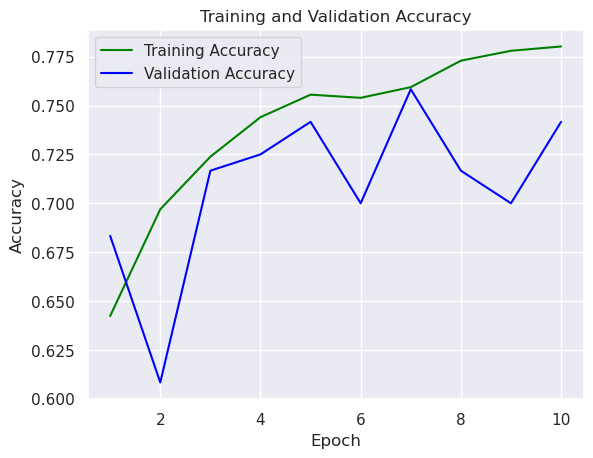

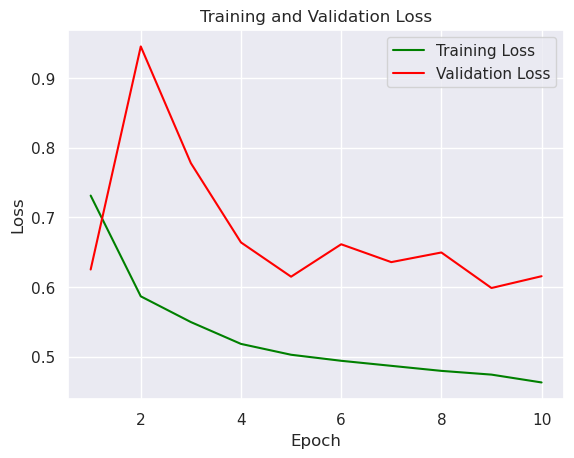

In [21]:
import seaborn as sns
sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='green', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()